# Trabajo Práctico 3: Como perros y gatos

## Análisis de datos

Contamos con un total de 8000 imagenes de perros y gatos para el dataset de entrenamiento y 2000 imagenes para el dataset de test/validation.

In [39]:
# de python, para especificar rutas de archivos y directorios
from pathlib import Path

# lib para trabajar con arrays
import numpy as np

# lib que usamos para mostrar las imágenes
import matplotlib.pyplot as plt

# libs que usamos para construir y entrenar redes neuronales, y que además tiene utilidades para leer sets de 
# imágenes
from keras.preprocessing import image_dataset_from_directory
from keras.models import Sequential
from keras.layers import Dense, Input, Dropout, Convolution2D, MaxPooling2D, Flatten
from keras.layers.experimental.preprocessing import Rescaling
from keras.preprocessing.image import load_img, img_to_array
from IPython.display import Image, display
from PIL import Image as PILImage
import os, os.path
from collections import Counter

# libs que usamos para tareas generales de machine learning. En este caso, métricas
from sklearn.metrics import accuracy_score, confusion_matrix

# configuración para que las imágenes se vean dentro del notebook
%matplotlib inline

In [2]:
CLASSES = "cats", "dogs"
TRAIN_DIR = Path('./imagenes_tp3_cv/training_set')
TEST_DIR = Path('./imagenes_tp3_cv/test_set')

In [38]:
imgs = []
images_amount = {}

valid_images = [".jpg"]
for CLASS in CLASSES:
    images_amount[CLASS] = 0
    path = './imagenes_tp3_cv/training_set/'+CLASS
    for f in os.listdir(path):
        ext = os.path.splitext(f)[1]
        if ext.lower() not in valid_images:
            continue
        imgs.append(PILImage.open(os.path.join(path,f)))
        images_amount[CLASS] += 1
        
counter = dict(Counter(getattr(image, 'size') for image in imgs))
c = max(counter, key = lambda x: x[1])
print("Resolución mas frecuente: ", c)

width=64 #c[0]
height=64 #c[1]

Resolución mas frecuente:  (1023, 768)


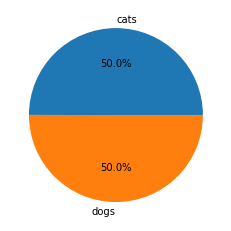

{'cats': 4000, 'dogs': 4005}

In [4]:
plt.pie([float(images_amount[v]) for v in images_amount], labels=[str(k) for k in images_amount], autopct='%1.1f%%')
plt.show()
images_amount

#### Tamaño de imagenes
La distribucion en los tamaños de las imagenes es demasiado amplia y , por eso optamos por una resolucion de 64x64 priorizando la velocidad en el entrenamiento de los modelos ya que observamos resultados satisfactorios.

In [5]:
counter

{(300, 280): 1,
 (489, 499): 5,
 (403, 499): 3,
 (150, 149): 3,
 (336, 499): 3,
 (379, 407): 1,
 (259, 269): 1,
 (499, 375): 929,
 (500, 333): 18,
 (500, 374): 940,
 (328, 368): 1,
 (353, 400): 1,
 (296, 200): 1,
 (500, 273): 2,
 (500, 480): 3,
 (344, 335): 2,
 (499, 377): 17,
 (288, 287): 1,
 (238, 240): 2,
 (349, 343): 2,
 (271, 360): 1,
 (358, 499): 6,
 (500, 472): 1,
 (349, 315): 1,
 (484, 445): 1,
 (475, 315): 1,
 (437, 396): 1,
 (500, 323): 1,
 (500, 386): 4,
 (500, 331): 34,
 (335, 448): 6,
 (229, 254): 1,
 (499, 365): 1,
 (374, 499): 5,
 (253, 399): 1,
 (462, 431): 1,
 (482, 465): 1,
 (349, 262): 23,
 (499, 445): 4,
 (382, 500): 2,
 (350, 500): 3,
 (215, 174): 1,
 (429, 259): 1,
 (399, 360): 2,
 (311, 310): 1,
 (375, 499): 83,
 (284, 341): 1,
 (400, 374): 1,
 (329, 245): 1,
 (479, 360): 18,
 (499, 300): 1,
 (240, 158): 1,
 (500, 373): 30,
 (300, 224): 24,
 (407, 398): 1,
 (279, 226): 1,
 (499, 350): 4,
 (500, 399): 6,
 (419, 442): 1,
 (199, 250): 2,
 (334, 327): 1,
 (499, 355):

## Modelos

In [6]:
def print_predictions_table (model, train_set, test_set):
    datasets = (
        ("train", train_set),
        ("test", test_set),   
    )
    for dataset_name, dataset in datasets:
        print('#' * 25, dataset_name, '#' * 25)

        # el dataset se itera en batches, así que calculams predicciones y labels por cada batch, y luego 
        # concatenamos todo
        batches_predictions = []
        batches_labels =  []

        for batch_images, batch_labels in dataset:
            # super importante: usamos argmax para convertir cosas de este formato:
            # [(0, 1, 0), (1, 0, 0), (1, 0, 0), (0, 0, 1)]
            # a este formato (donde tenemos el índice de la clase que tiene número más alto):
            # [1, 0, 0, 2]
            batches_predictions.append(np.argmax(model.predict(batch_images), axis=-1))
            batches_labels.append(np.argmax(batch_labels, axis=-1))

        predictions = np.concatenate(batches_predictions)
        labels = np.concatenate(batches_labels)

        print('accuracy', accuracy_score(labels, predictions))

        # graficamos la confussion matrix
        plt.figure(figsize=(3, 4))

        plt.xticks([0, 1], CLASSES, rotation=45)
        plt.yticks([0, 1], CLASSES)
        plt.xlabel('Predicted class')
        plt.ylabel('True class')

        plt.imshow(
            confusion_matrix(labels, predictions), 
            cmap=plt.cm.Blues,
            interpolation='nearest',
        )

        plt.show()

# MLP Convulsional

In [7]:
train_cvl = image_dataset_from_directory(
    TRAIN_DIR,
    labels="inferred",
    label_mode="categorical",
    class_names=CLASSES,
    color_mode="grayscale",
    image_size=(width, height),
    shuffle=True,
    seed=14,
)

test_cvl = image_dataset_from_directory(
    TEST_DIR,
    labels="inferred",
    label_mode="categorical",
    class_names=CLASSES,
    color_mode="grayscale",
    image_size=(width, height),
    shuffle=True,
    seed=14,
)

Found 8005 files belonging to 2 classes.
Found 2023 files belonging to 2 classes.


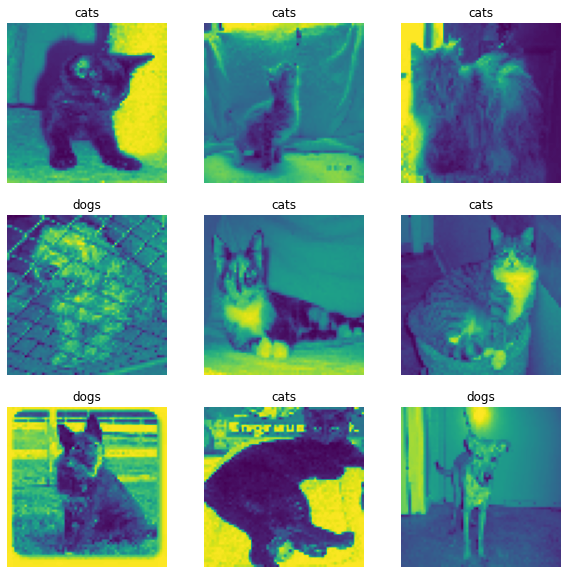

In [9]:
def sample_images(dataset):
    plt.figure(figsize=(10, 10))
    for images, labels in dataset.take(1):
        for i in range(9):
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(images[i].numpy().astype("uint8"))
            plt.title(CLASSES[np.argmax(labels[i])])
            plt.axis("off")
sample_images(train_cvl)

In [68]:
model_cvl = Sequential([
    Rescaling(1/255, input_shape=(width, height, 1)),
    
    #Convolution2D(filters=8, kernel_size=(2, 2), strides=1, activation='relu'),
    #Dropout(0.2),
    
    Convolution2D(filters=32, kernel_size=(3, 3), strides=1, activation='relu'),
    Dropout(0.2),
    
    
    Convolution2D(filters=16, kernel_size=(3, 3), strides=1, activation='relu'),
    Dropout(0.2),
    
    
    Convolution2D(filters=8, kernel_size=(3, 3), strides=1, activation='relu'),
    Dropout(0.2),
    
    
    
    MaxPooling2D(pool_size=(4, 4)),
    # salida de 14x14x8
    
    
    Flatten(),
    
    #Dense(100, activation='tanh'),
    #Dropout(0.2),    
    
    Dense(10, activation='tanh'),
    Dropout(0.2),
        
    Dense(10, activation='tanh'),
    Dropout(0.2),
    
    Dense(len(CLASSES), activation='softmax'),
])

model_cvl.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy',],
)

In [83]:
history_cvl = model_cvl.fit(
    train_cvl,
    epochs=1, #18 epochs totales
    batch_size=128,
    validation_data=test_cvl,
)

251/251 [==============================] - 37s 147ms/step - loss: 0.4184 - accuracy: 0.8179 - val_loss: 0.5148 - val_accuracy: 0.7588


In [ ]:
plt.plot(history_cvl.history['accuracy'], label='train')
plt.plot(history_cvl.history['val_accuracy'], label='validation')
plt.title('Accuracy over train epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

######################### train #########################
accuracy 0.83210493441599


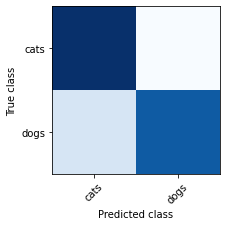

######################### test #########################
accuracy 0.7587740978744439


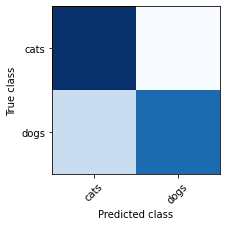

In [84]:
print_predictions_table(model_cvl, train_cvl, test_cvl)

## Predicciones

In [115]:
def predict(image_path, model, color_mode):
    image_array = img_to_array(load_img(image_path, target_size=(64, 64, 1), color_mode = color_mode))
    inputs = np.array([image_array])  
    predictions = model.predict(inputs)
    display(Image(image_path, width=200))
    print("Prediction:", CLASSES[np.argmax(predictions)])
    print("Prediction detail:", predictions)

### Gatos

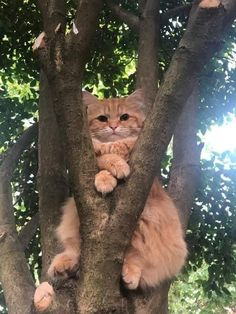

Prediction: dogs
Prediction detail: [[0.44561705 0.554383  ]]


In [116]:
predict('./ejemplos/gato_arbol.jpg', model_cvl, "grayscale")

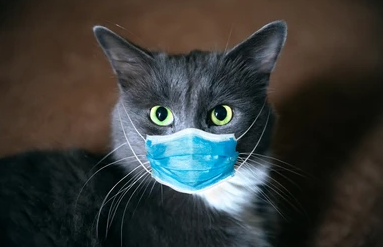

Prediction: cats
Prediction detail: [[0.6266593 0.3733407]]


In [87]:
predict('./ejemplos/gato_barbijo.png', model_cvl, "grayscale")

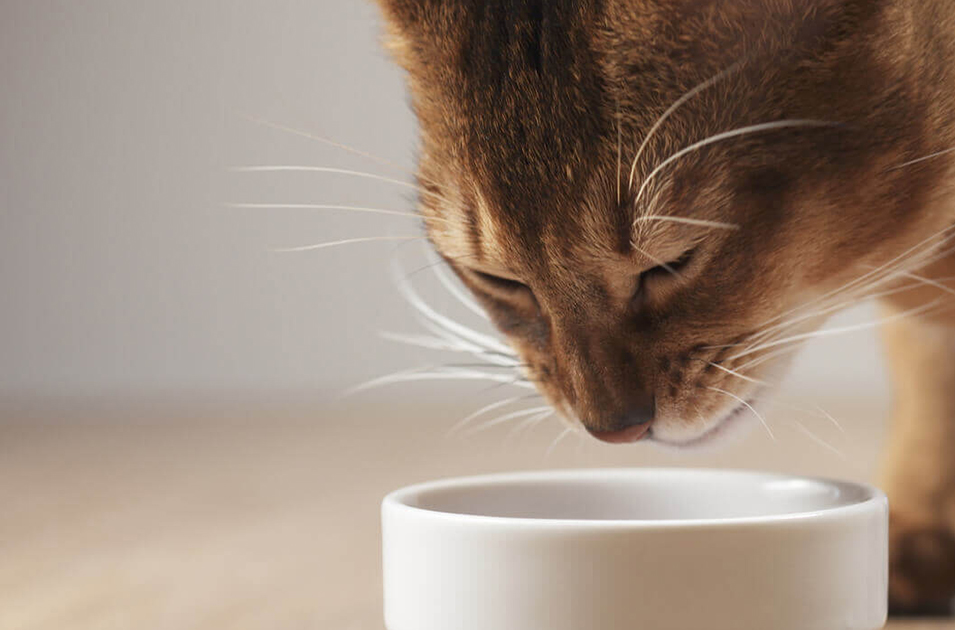

Prediction: cats
Prediction detail: [[0.8596391  0.14036083]]


In [88]:
predict('./ejemplos/gato_tarro.jpeg', model_cvl, "grayscale")

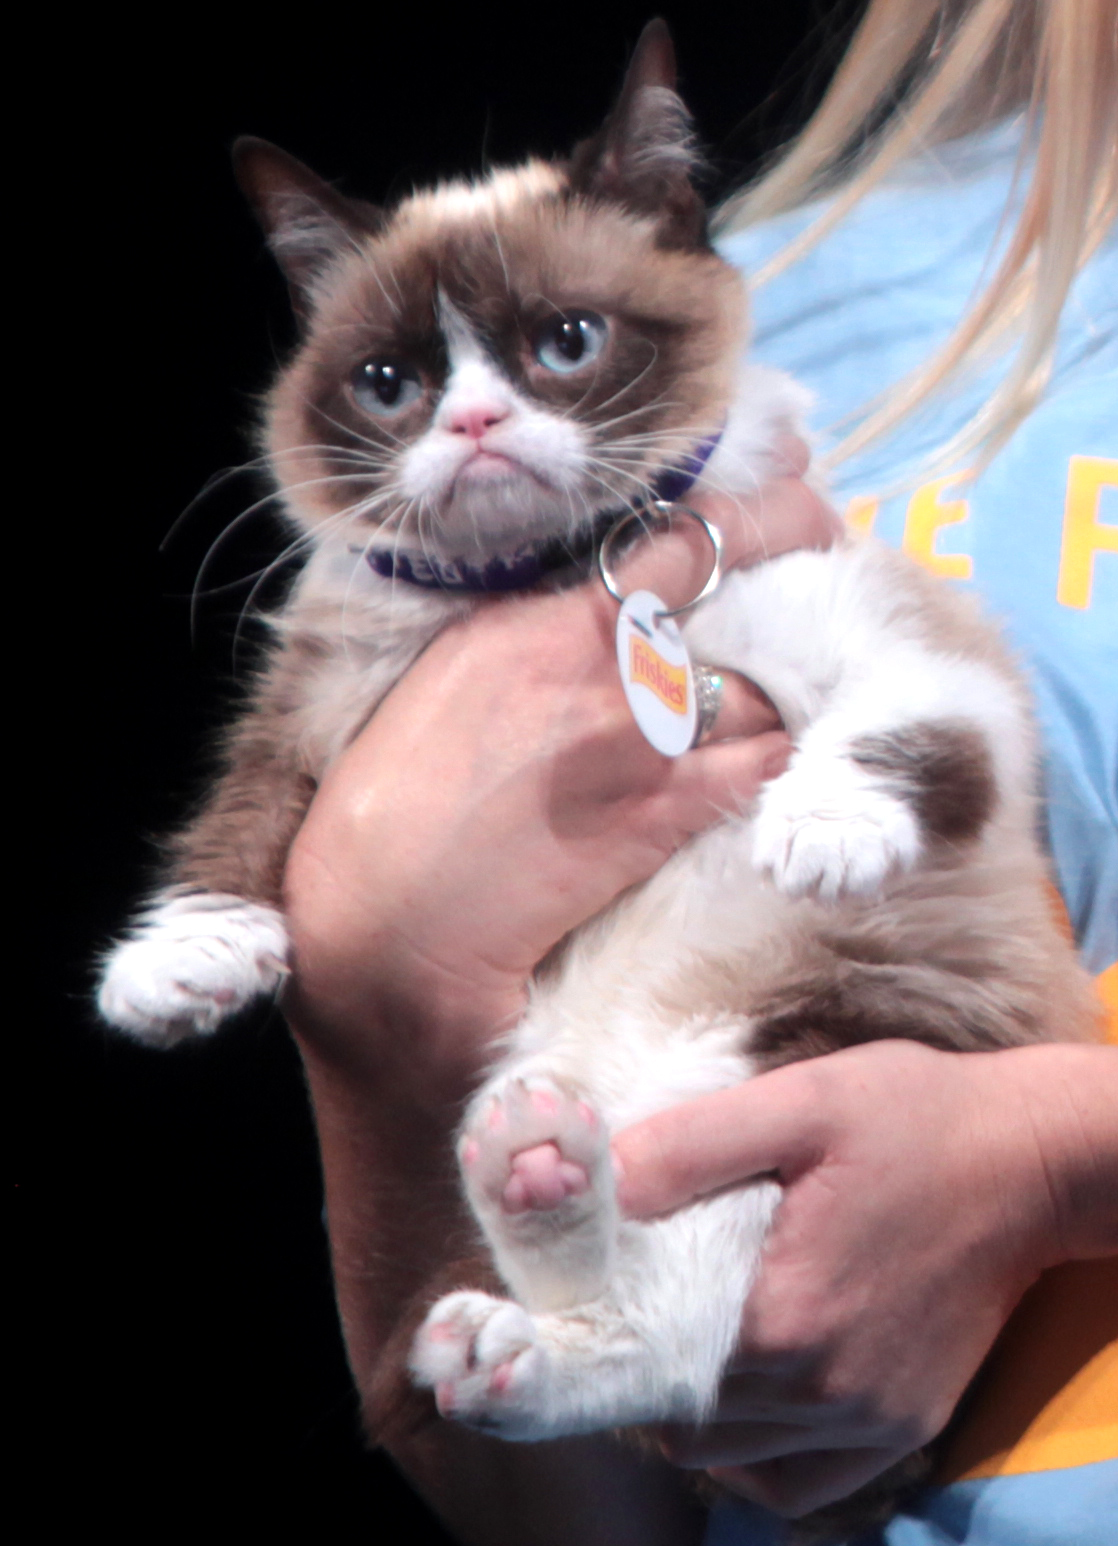

Prediction: cats
Prediction detail: [[0.96571434 0.03428564]]


In [89]:
predict('./ejemplos/gato_enojado.jpg', model_cvl, "grayscale")

### Perros

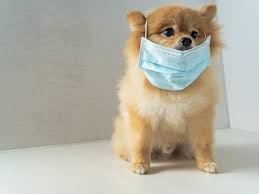

Prediction: cats
Prediction detail: [[0.868878   0.13112198]]


In [90]:
predict('./ejemplos/perro_barbijo.jpg', model_cvl, "grayscale")

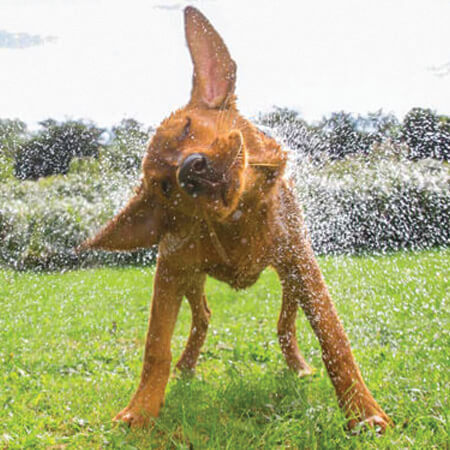

Prediction: dogs
Prediction detail: [[0.23554687 0.7644531 ]]


In [92]:
predict('./ejemplos/perro_sacudida.jpg', model_cvl, "grayscale")

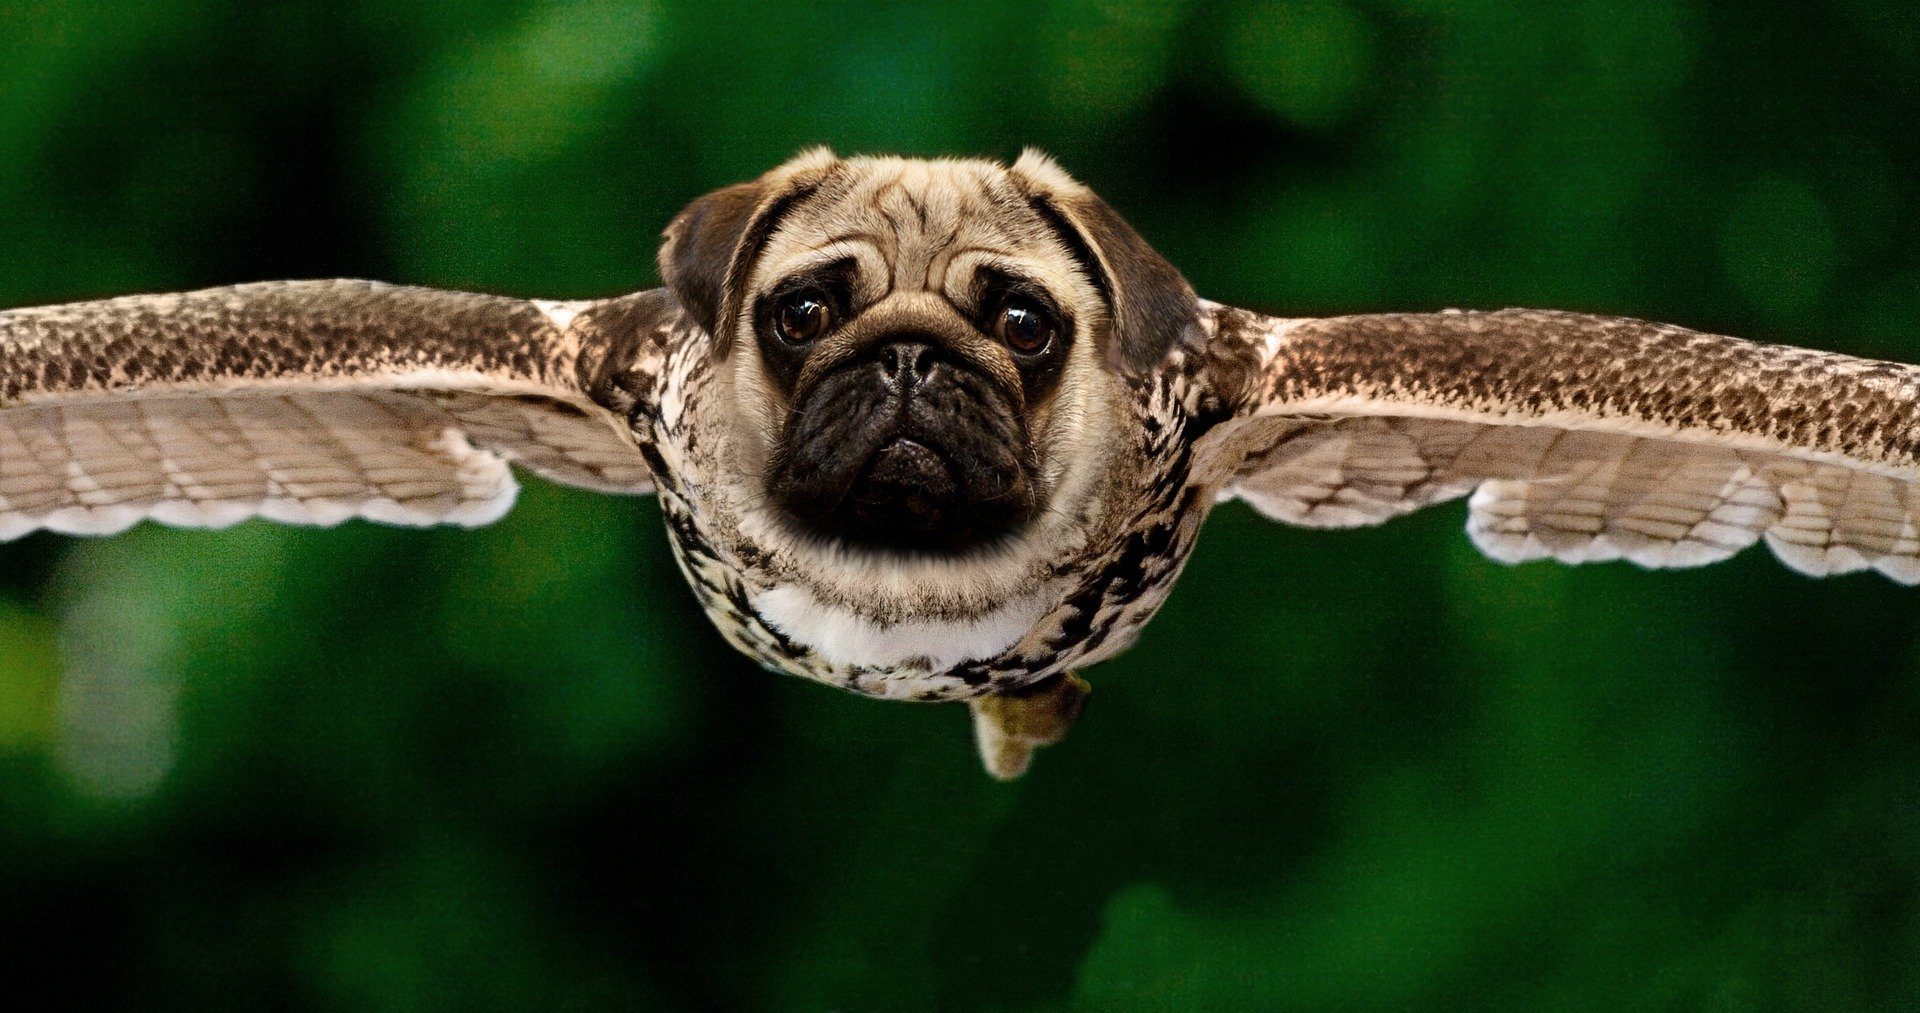

Prediction: dogs
Prediction detail: [[0.1528313  0.84716874]]


In [93]:
predict('./ejemplos/perro_volador.jpg', model_cvl, "grayscale")

# MLP Simple

In [94]:
train_simple = image_dataset_from_directory(
    TRAIN_DIR,
    labels="inferred",
    label_mode="categorical",
    class_names=CLASSES,
    color_mode="rgb",
    image_size=(width, height),
    shuffle=True,
    seed=14,
)

test_simple = image_dataset_from_directory(
    TEST_DIR,
    labels="inferred",
    label_mode="categorical",
    class_names=CLASSES,
    color_mode="rgb",
    image_size=(width, height),
    shuffle=True,
    seed=14,
)

Found 8005 files belonging to 2 classes.
Found 2023 files belonging to 2 classes.


In [136]:
model_simple = Sequential([
    Rescaling(1/255, input_shape=(width, height, 3)),
    
    Dense(30, activation='relu'),
    Dropout(0.2),
    Flatten(),
    
    Dense(300, activation='relu'),
    Dense(300, activation='relu'),
    Dropout(0.2),
    Dense(200, activation='relu'),
    Dropout(0.2),
    Dense(100, activation='relu'),
    Dropout(0.2),
    Dense(50, activation='relu'),
    Dropout(0.2),
    Dense(50, activation='relu'),
    Dropout(0.2),
    Dense(25, activation='relu'),
    Dropout(0.2),
    
    Dense(len(CLASSES), activation='sigmoid'),
])

model_simple.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy',],
)

In [139]:
history_simple = model_simple.fit(
    train_simple,
    epochs=1,#12
    batch_size=128,
    validation_data=test_simple,
)

251/251 [==============================] - 74s 293ms/step - loss: 0.5152 - accuracy: 0.7455 - val_loss: 0.6640 - val_accuracy: 0.6901


In [ ]:
plt.plot(history_simple.history['accuracy'], label='train')
plt.plot(history_simple.history['val_accuracy'], label='validation')
plt.title('Accuracy over train epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

######################### train #########################
accuracy 0.7855090568394754


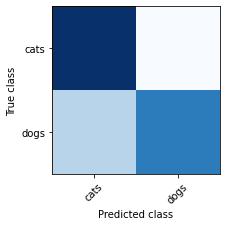

######################### test #########################
accuracy 0.690064260998517


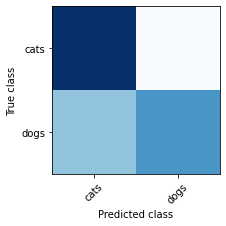

In [140]:
print_predictions_table(model_simple, train_simple, test_simple)

## Predicciones

### Gatos

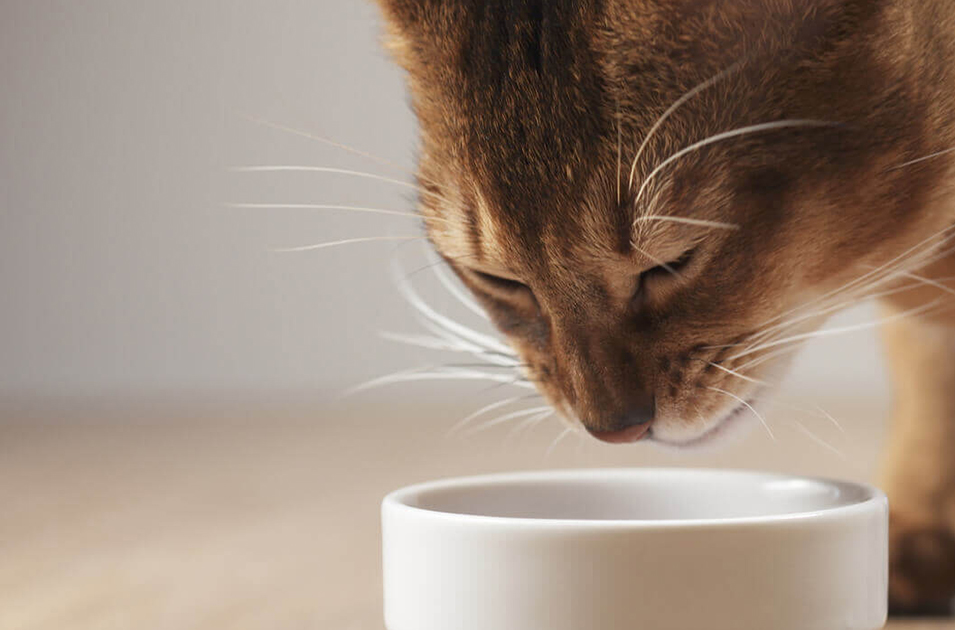

Prediction: cats
Prediction detail: [[0.60200775 0.3913359 ]]


In [141]:
predict('./ejemplos/gato_tarro.jpeg', model_simple, "rgb")

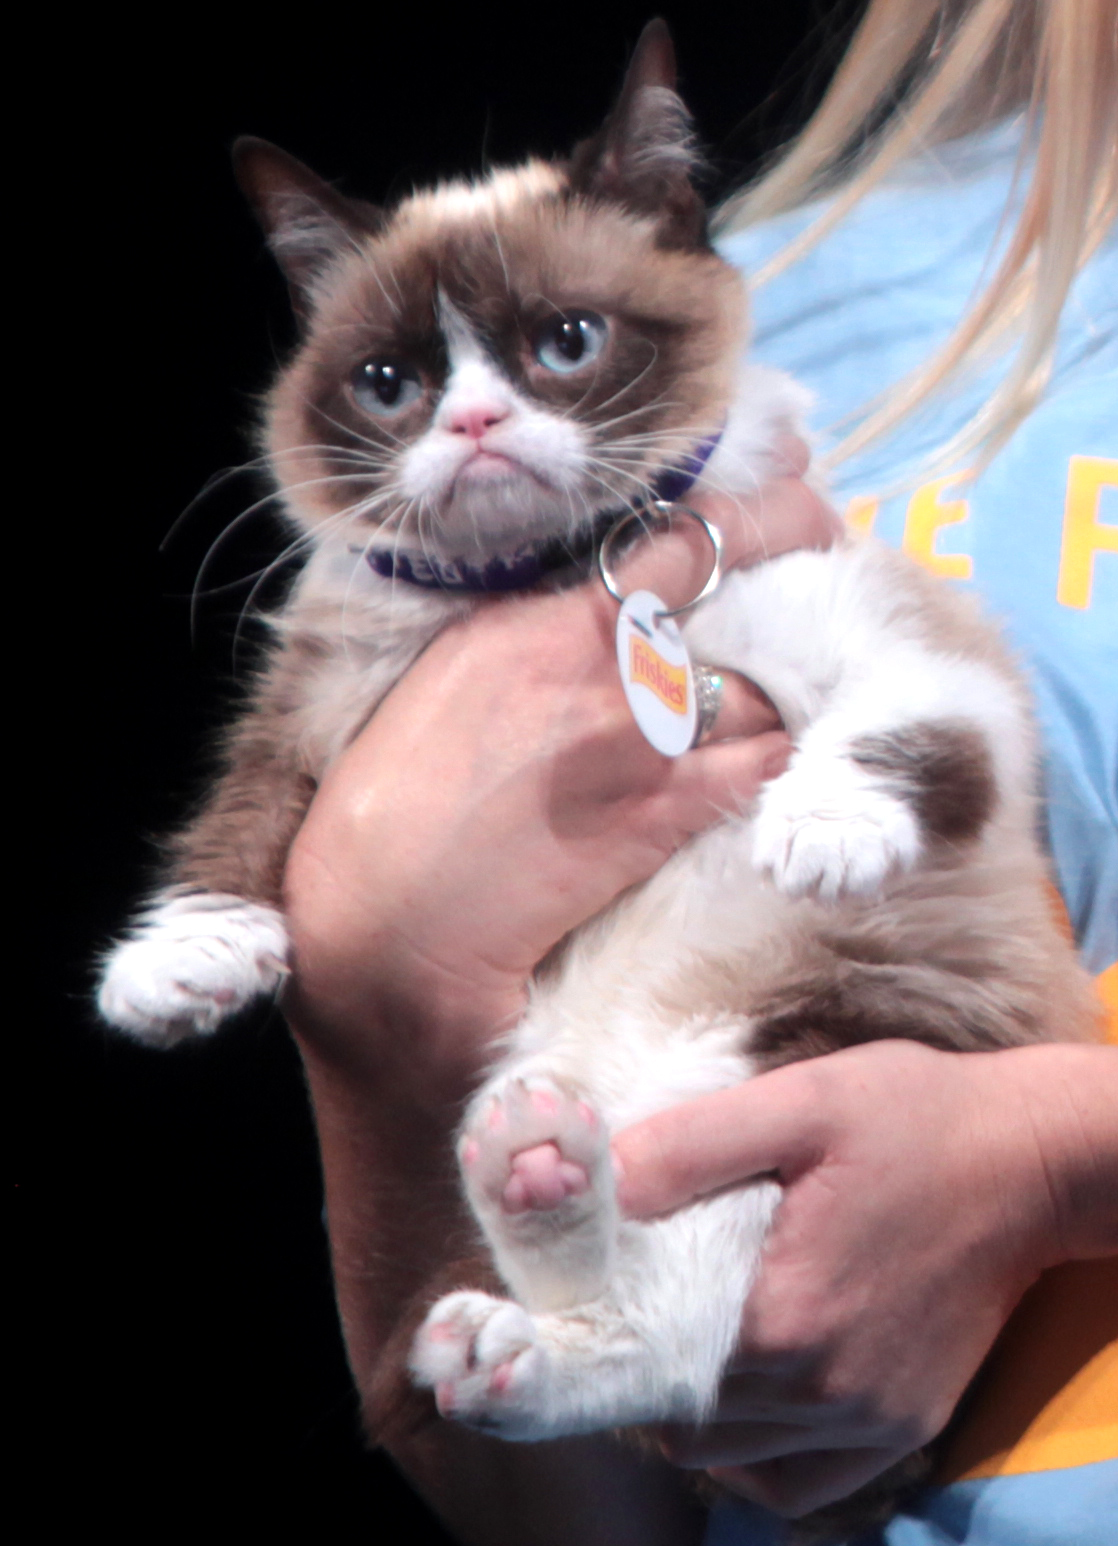

Prediction: cats
Prediction detail: [[0.6973991  0.33829394]]


In [142]:
predict('./ejemplos/gato_enojado.jpg', model_simple, "rgb")

### Perros

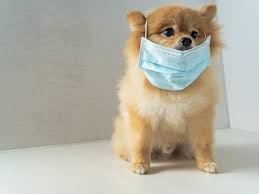

Prediction: dogs
Prediction detail: [[0.28190258 0.42173782]]


In [143]:
predict('./ejemplos/perro_barbijo.jpg', model_simple, "rgb")

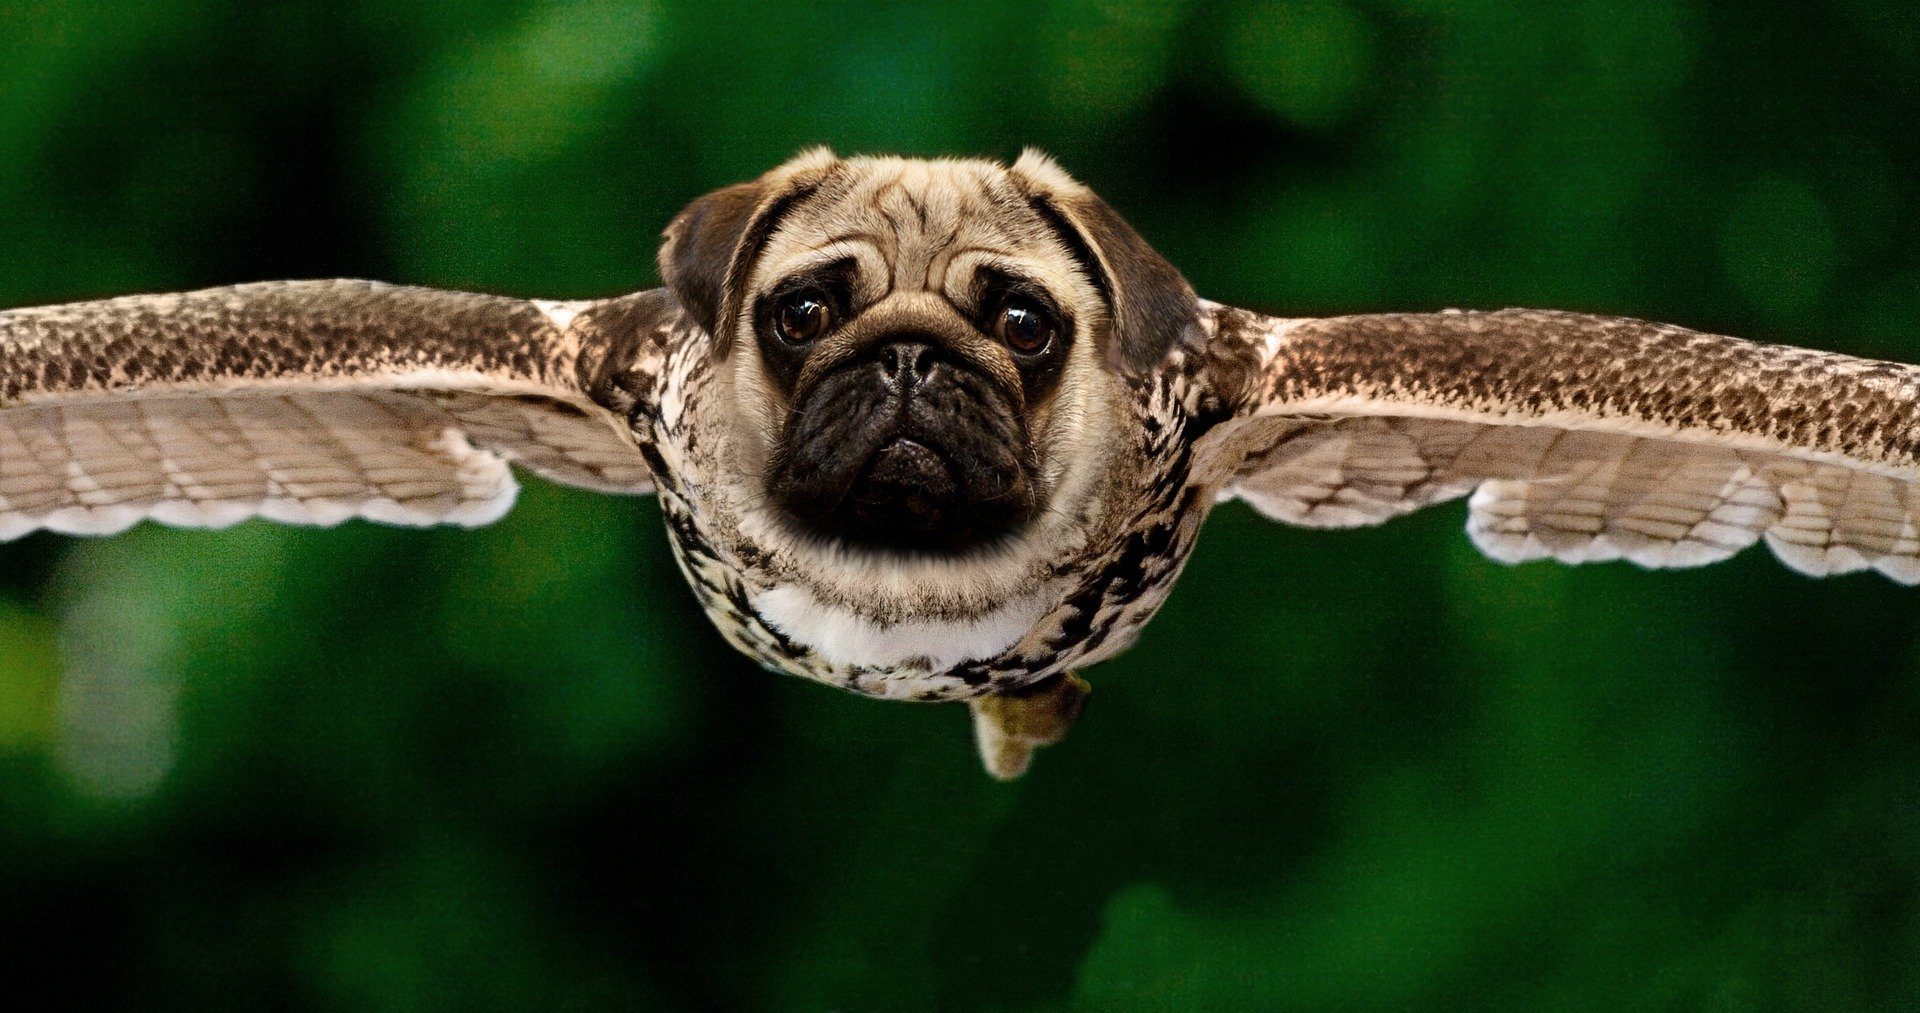

Prediction: dogs
Prediction detail: [[1.4478805e-06 6.9529802e-02]]


In [144]:
predict('./ejemplos/perro_volador.jpg', model_simple, "rgb")